# Quantile Regression

Try to achieve a quantile regression with simulated data, the math details will not be 
discussed right now, only the implementation.

## Model form (breakpoint at $c$)

$
Q_y(\tau \mid x) =
\begin{cases}
\beta_0 + \beta_1 x, & x \leq c \\
\beta_2 + \beta_3 x, & x > c
\end{cases}
$

- Different intercepts: $\beta_0 \neq \beta_2$ is allowed
- Allows a sudden change in both slope and level

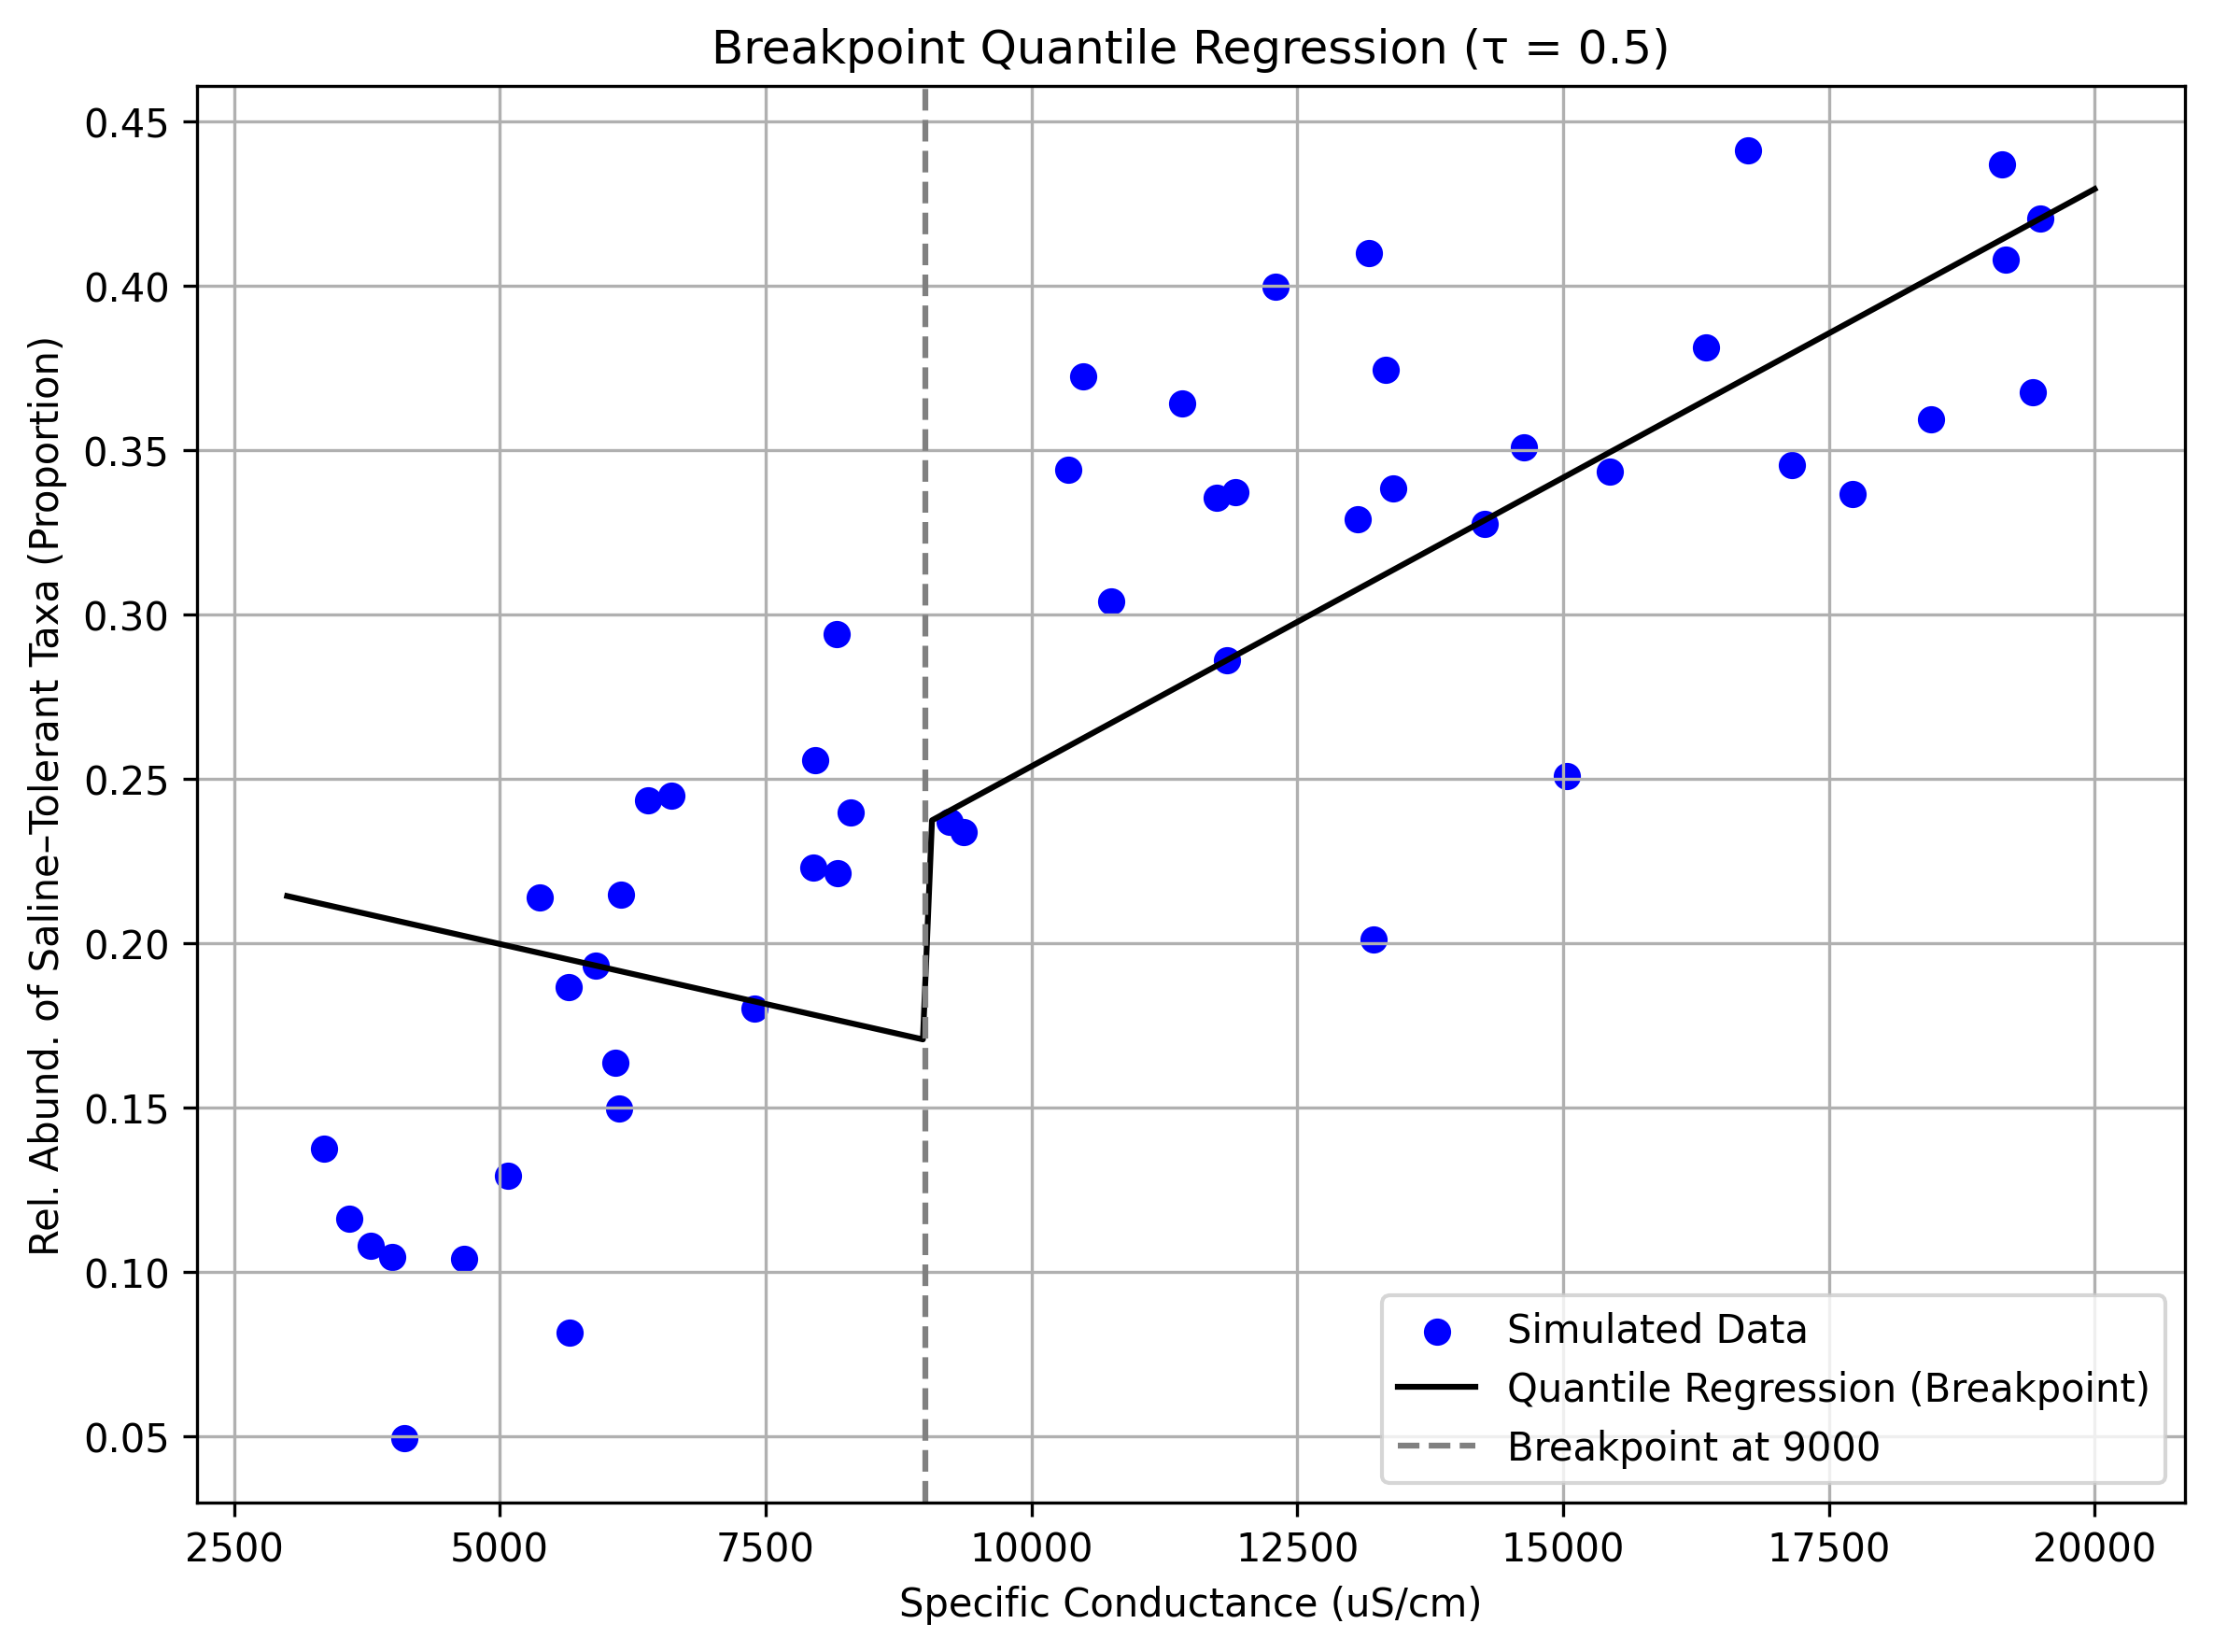

In [3]:
# Re-run after kernel reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Simulate data similar to the scatterplot in the image
np.random.seed(42)
n = 50
x = np.sort(np.random.uniform(3000, 20000, size=n))

# Simulate a breakpoint effect at ~9000 µS/cm
breakpoint = 9000
y = np.piecewise(x,
                 [x <= breakpoint, x > breakpoint],
                 [lambda x: 0.00003 * x + np.random.normal(0, 0.05, len(x)),
                  lambda x: 0.00001 * x + 0.2 + np.random.normal(0, 0.05, len(x))])

# Clamp to [0, 1] as it's a proportion
y = np.clip(y, 0, 1)

# Create DataFrame
df = pd.DataFrame({'x': x, 'y': y})

# Fit two quantile regressions with a known breakpoint
df['x1'] = df['x'] * (df['x'] <= breakpoint)
df['x2'] = (df['x'] - breakpoint) * (df['x'] > breakpoint)

# Fit quantile regression
model = smf.quantreg('y ~ x1 + x2', df)
res = model.fit(q=0.5)

# Predict
x_plot = np.linspace(3000, 20000, 200)
x1_plot = x_plot * (x_plot <= breakpoint)
x2_plot = (x_plot - breakpoint) * (x_plot > breakpoint)
df_plot = pd.DataFrame({'x1': x1_plot, 'x2': x2_plot})
y_pred = res.predict(df_plot)

# Plotting
fig, ax1 = plt.subplots(figsize=(8, 6), dpi=300)
ax1.scatter(df['x'], df['y'], color='blue', label='Simulated Data')
ax1.plot(x_plot, y_pred, color='black', label='Quantile Regression (Breakpoint)')
ax1.axvline(breakpoint, color='gray', linestyle='--', label=f'Breakpoint at {breakpoint}')
ax1.set_xlabel("Specific Conductance (uS/cm)")
ax1.set_ylabel("Rel. Abund. of Saline–Tolerant Taxa (Proportion)")
ax1.set_title("Breakpoint Quantile Regression (τ = 0.5)")
ax1.legend()
ax1.grid(True)
fig.tight_layout()
plt.show()

## Model form (using hinge/truncated linear term)

$
Q_y(\tau \mid x) = \beta_0 + \beta_1 x + \beta_2 (x - c)_+
$

- $(x - c)_+ = \max(0, x - c)$
- Only one intercept $\beta_0$, ensuring continuity
- Slope changes after the breakpoint: $\beta_1$ before, $\beta_1 + \beta_2$ after

A breakpoint estimation with quantile regression that is continuous at the breakpoint.

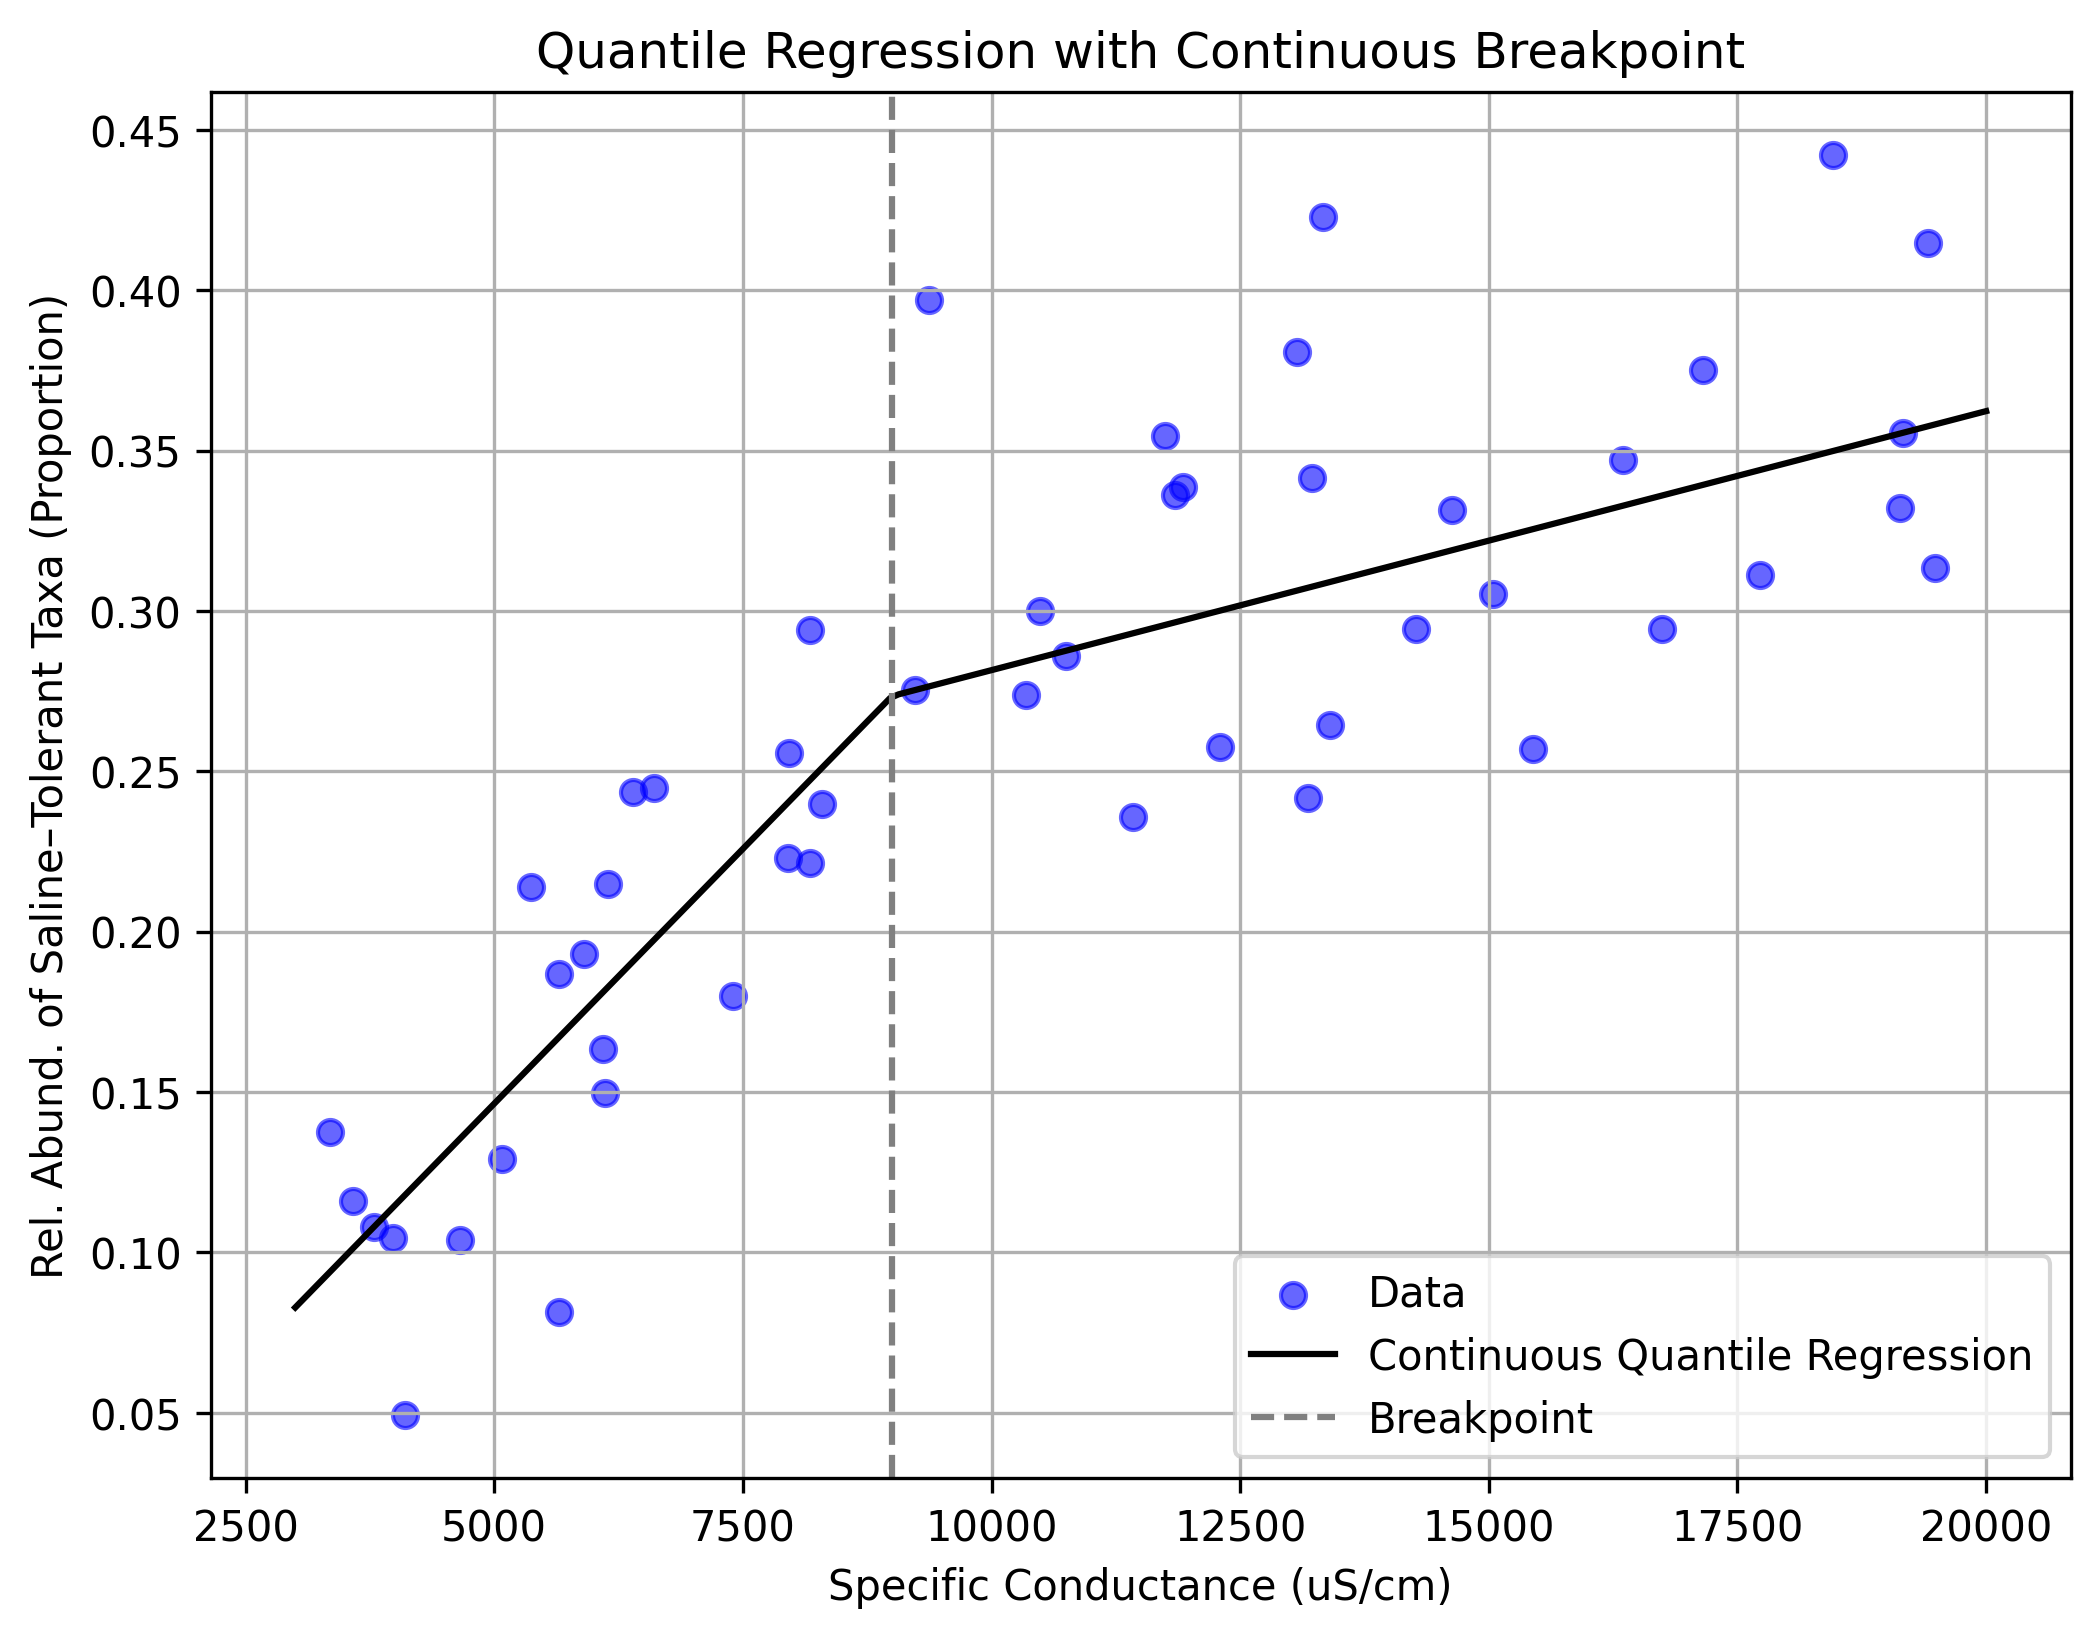

In [4]:
# Simulate data similar to the scatter plot
np.random.seed(42)
n = 50
x = np.sort(np.random.uniform(3000, 20000, n))
breakpoint = 9000
y = np.where(
    x <= breakpoint,
    0.00003 * x + np.random.normal(0, 0.05, n),
    0.00003 * breakpoint + 0.00001 * (x - breakpoint) + np.random.normal(0, 0.05, n)
)
y = np.clip(y, 0, 1)

# Create DataFrame
df = pd.DataFrame({'x': x, 'y': y})

# Construct a continuous piecewise linear variable
df['x_bp'] = np.where(df['x'] > breakpoint, df['x'] - breakpoint, 0)

# Fit quantile regression model with continuity at breakpoint
quantile = 0.5
model = smf.quantreg('y ~ x + x_bp', df)
res = model.fit(q=quantile)

# Prepare predictions
x_vals = np.linspace(3000, 20000, 200)
x_bp_vals = np.where(x_vals > breakpoint, x_vals - breakpoint, 0)
pred_df = pd.DataFrame({'x': x_vals, 'x_bp': x_bp_vals})
y_pred = res.predict(pred_df)

# Plot
fig2, axes2 = plt.subplots(figsize=(8, 6), dpi=300)
axes2.scatter(df['x'], df['y'], color='blue', label='Data', alpha=0.6)
axes2.plot(x_vals, y_pred, color='black', label='Continuous Quantile Regression')
axes2.axvline(x=breakpoint, color='gray', linestyle='--', label='Breakpoint')
axes2.set_xlabel("Specific Conductance (uS/cm)")
axes2.set_ylabel("Rel. Abund. of Saline–Tolerant Taxa (Proportion)")
axes2.set_title("Quantile Regression with Continuous Breakpoint")
axes2.legend()
axes2.grid(True)
plt.show()

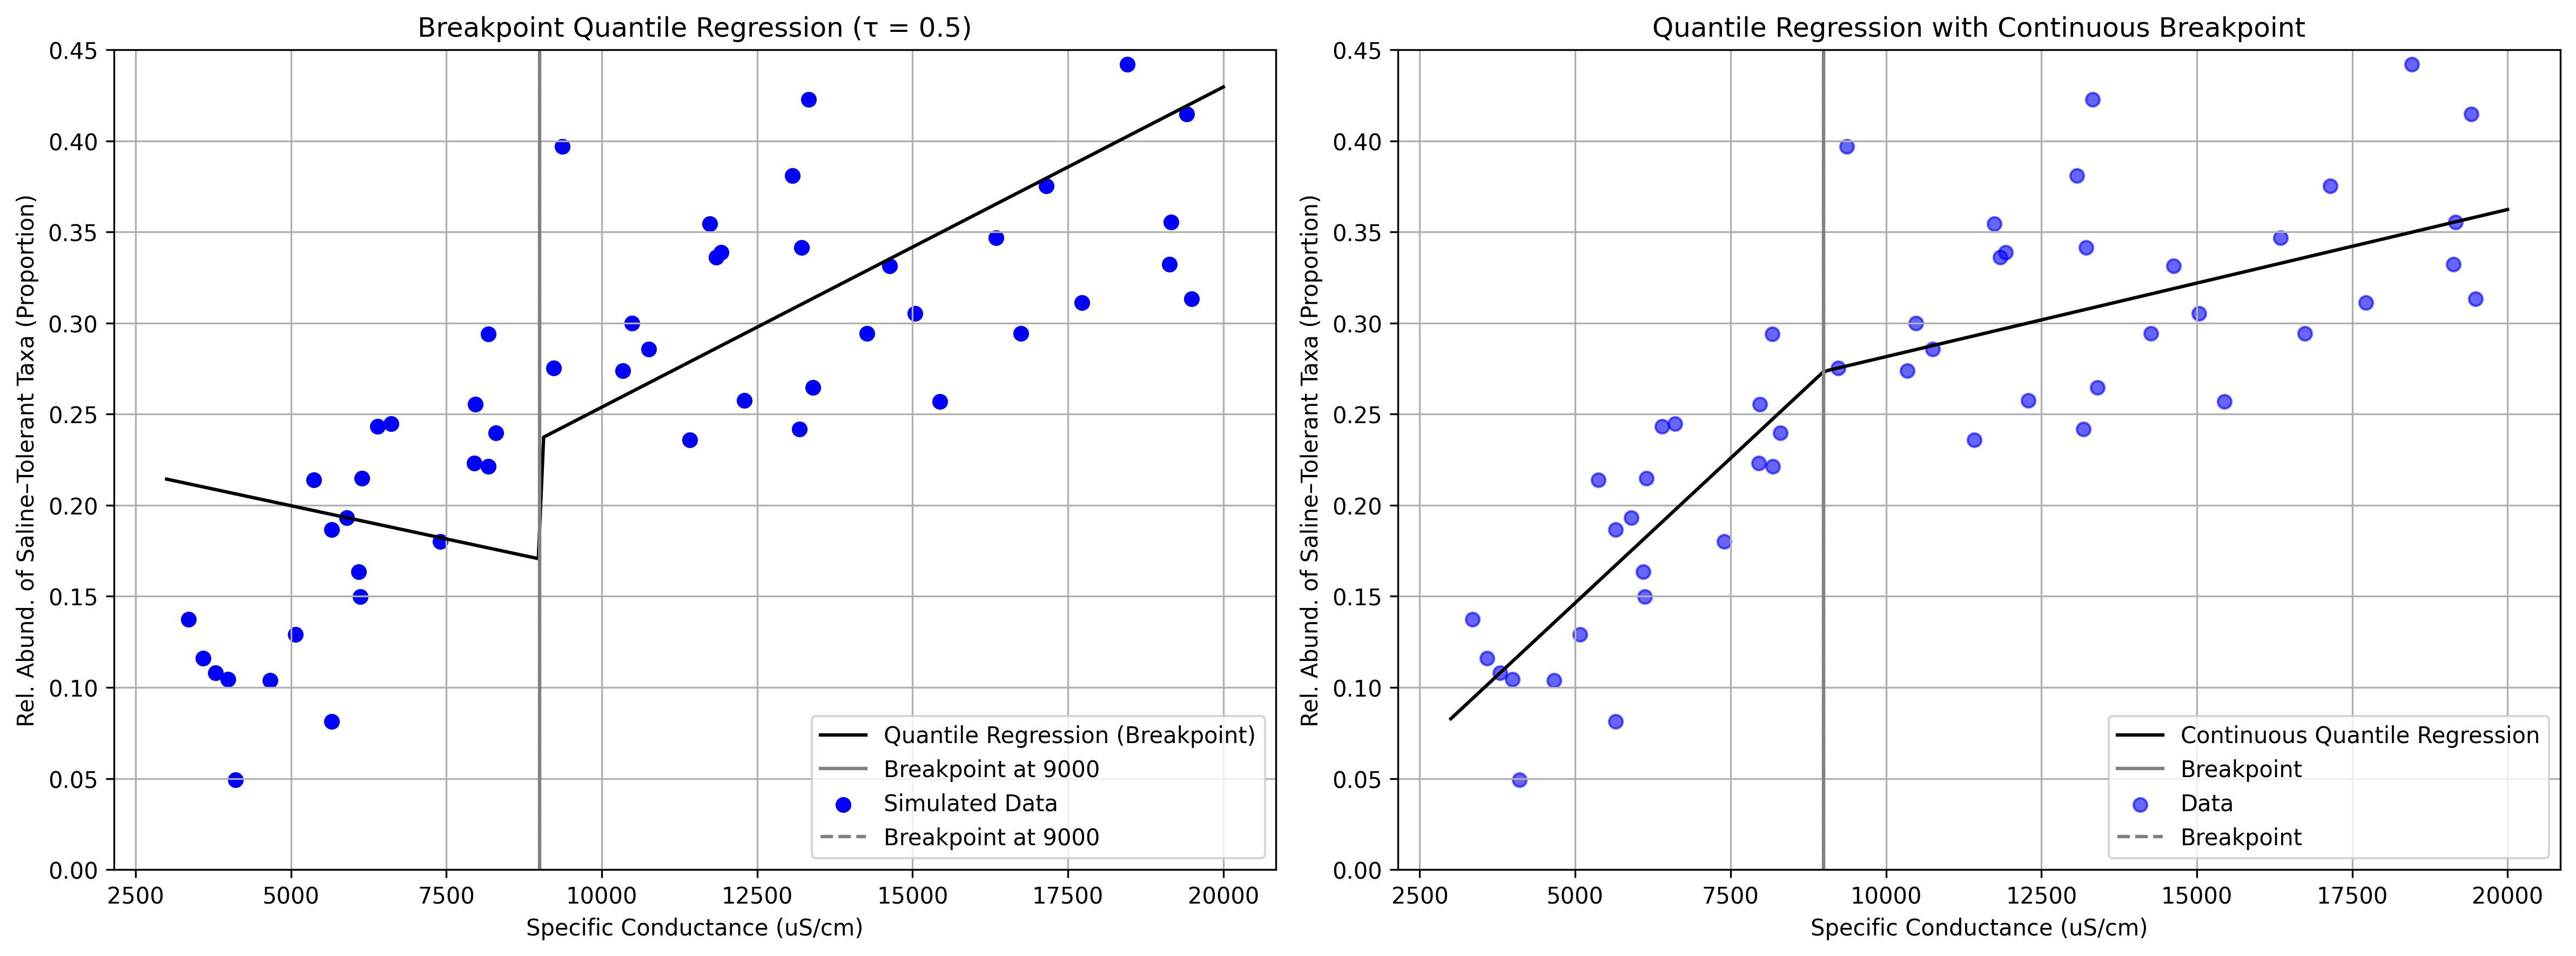

In [5]:
# Create a new figure with two subplots
fig_combined, (ax_combined1, ax_combined2) = plt.subplots(1, 2, figsize=(16, 6), dpi=300)

# Copy the content of ax1 to ax_combined1
for line in ax1.get_lines():
    ax_combined1.plot(line.get_xdata(), line.get_ydata(), label=line.get_label(), color=line.get_color())
ax_combined1.scatter(df['x'], df['y'], color='blue', label='Simulated Data')
ax_combined1.axvline(breakpoint, color='gray', linestyle='--', label=f'Breakpoint at {breakpoint}')
ax_combined1.set_title(ax1.get_title())
ax_combined1.set_xlabel(ax1.get_xlabel())
ax_combined1.set_ylabel(ax1.get_ylabel())
ax_combined1.legend()
ax_combined1.grid(True)

# Copy the content of axes2 to ax_combined2
for line in axes2.get_lines():
    ax_combined2.plot(line.get_xdata(), line.get_ydata(), label=line.get_label(), color=line.get_color())
ax_combined2.scatter(df['x'], df['y'], color='blue', label='Data', alpha=0.6)
ax_combined2.axvline(x=breakpoint, color='gray', linestyle='--', label='Breakpoint')
ax_combined2.set_title(axes2.get_title())
ax_combined2.set_xlabel(axes2.get_xlabel())
ax_combined2.set_ylabel(axes2.get_ylabel())
ax_combined2.legend()
ax_combined2.grid(True)

# Set the y-axis limits for both subplots
ax_combined1.set_ylim(0, 0.45)
ax_combined2.set_ylim(0, 0.45)

# Adjust layout and show the combined figure
fig_combined.tight_layout()
fig_combined.savefig("results/breakpoint_quantile_regression.png", dpi=300)
plt.show()

# Create a map

In [22]:
import random
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

def map_plot(ax):
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
    # Load the full shapefile
    gdf = gpd.read_file("lpr_000b16a_e/lpr_000b16a_e.shp")
    # Filter to BC
    bc = gdf[gdf["PRNAME"].str.contains("British Columbia")]
    bc.plot(ax=ax, edgecolor="black", color="lightblue", alpha = 0.5)


    # Load municipal polygon data
    muni_gdf = gpd.read_file("BCGW_02001F02_1747091351300_2028/ABMS_MUNICIPALITIES_SP/ABMS_MUNI_polygon.shp")
    muni_gdf = muni_gdf.to_crs(bc.crs)  # bc is your British Columbia GeoDataFrame
    muni_gdf.plot(ax=ax, edgecolor="black", color='#1b9e77', alpha=0.7)

    # Define Kamloops point in lon/lat (WGS84)
    kamloops_point = gpd.GeoDataFrame(
        geometry=[Point(-120.3273, 50.6745)],
        crs="EPSG:4326"  # WGS 84
    )
    # Reproject to match BC shapefile CRS
    kamloops_proj = kamloops_point.to_crs(bc.crs)
    # Plot Kamloops point
    kamloops_proj.plot(ax=ax, color='orange', markersize=20, alpha = 0.7, label='Kamloops')


    # Define Vancouver point in lon/lat (WGS84)
    vancouver_point = gpd.GeoDataFrame(
        geometry=[Point(-123.1207, 49.2827)],
        crs="EPSG:4326"  # WGS 84
    )
    # Reproject to match BC shapefile CRS
    vancouver_proj = vancouver_point.to_crs(bc.crs)
    # Plot Vancouver point
    vancouver_proj.plot(ax=ax, color='blue', markersize=20, alpha=0.7, label='Vancouver')


    # Create a line connecting Vancouver and Kamloops
    line = LineString([vancouver_proj.geometry.iloc[0], kamloops_proj.geometry.iloc[0]])

    # Plot the line
    gpd.GeoSeries([line]).plot(ax=ax, color='green', linewidth=1, label='Connection Line')

    # Add annotation near the line
    midpoint = line.interpolate(0.5, normalized=True)
    ax.annotate("Kamloops to Vancouver", xy=(midpoint.x, midpoint.y), xytext=(midpoint.x + 50000, midpoint.y + 50000),
                arrowprops=dict(facecolor='black', arrowstyle="->"), fontsize=8, color='green')


    # Choose the northernmost and southernmost points from the municipalities GeoDataFrame
    northern_point = muni_gdf.geometry.iloc[muni_gdf.geometry.centroid.y.idxmax()].centroid
    southern_point = muni_gdf.geometry.iloc[muni_gdf.geometry.centroid.y.idxmin()].centroid
    southern_point = Point(southern_point.x - 100000, southern_point.y + 600000)

    # Create a line connecting the northernmost and southernmost points
    specific_line = LineString([northern_point, southern_point])

    # Plot the line
    gpd.GeoSeries([specific_line]).plot(ax=ax, color='purple', linewidth=1, label='A Connection')

    # Add annotation near the line
    specific_midpoint = specific_line.interpolate(0.5, normalized=True)
    ax.annotate("A Random Line Element", xy=(specific_midpoint.x, specific_midpoint.y), 
                xytext=(specific_midpoint.x + 50000 , specific_midpoint.y + 100000),
                arrowprops=dict(facecolor='black', arrowstyle="->"), fontsize=8, color='purple')


    # Add legend and formatting
    ax.set_title("British Columbia with Municipal Districts", fontsize=9)
    ax.legend(fontsize=4, loc='center left', bbox_to_anchor=(1, 0.5))
    return ax

# PCA from Singular Value Decomposition

I want to use the SVD to perform PCA because it provides me more flexibility in adjusting and combining this method with other methods, like bootstrapping and 
quantile regression.

<>:34: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\s'
/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_86373/2176813913.py:34: SyntaxWarning: invalid escape sequence '\s'
  label=f'$\sigma=${round(length, 2)}, PC:{v.round(4)}')


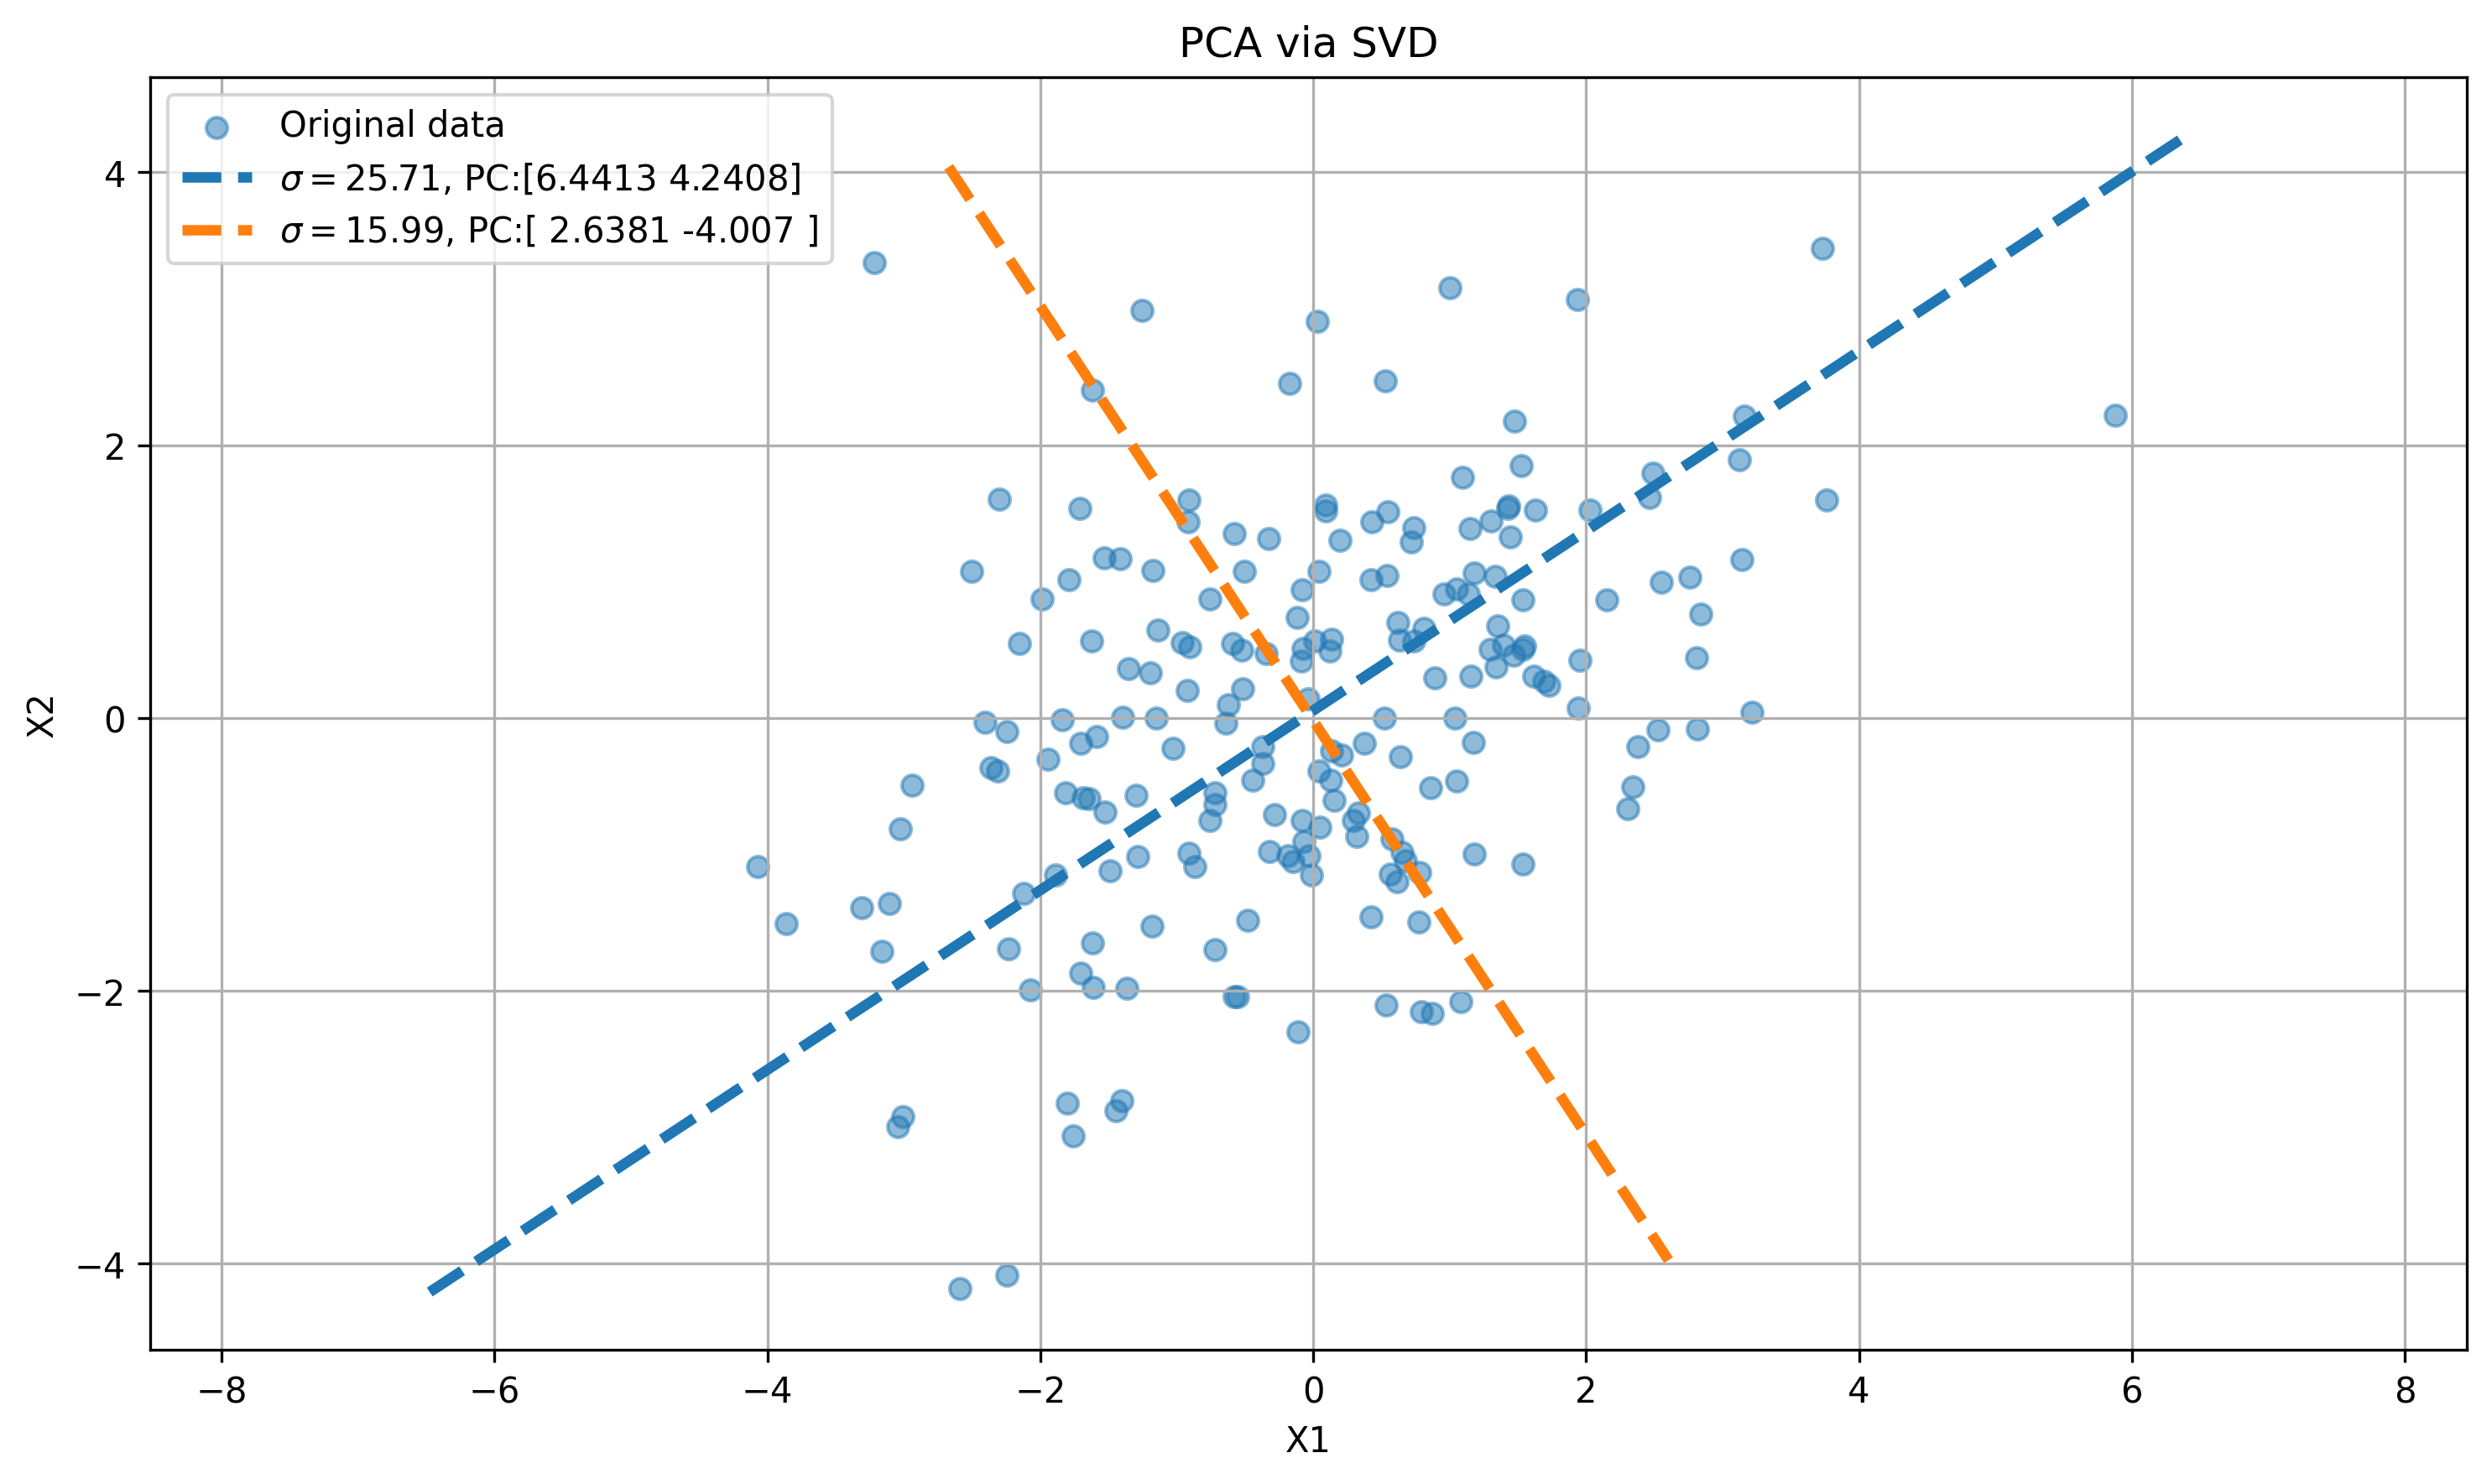

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Simulate a 2D dataset
np.random.seed(42)
mean = [0, 0]
cov = [[3, 1], [1, 2]]  # Covariance matrix
X = np.random.multivariate_normal(mean, cov, size=200)

# Step 2: Center the data
X_centered = X - np.mean(X, axis=0)

# Step 3: Apply SVD
U, S, VT = np.linalg.svd(X_centered)

# Principal components (directions)
PCs = VT.T

# Step 4: Project the data onto the principal components
X_pca = X_centered @ PCs

# Step 5: Visualize original data and PCs on axes3
fig3, axes3 = plt.subplots(figsize=(10, 6), dpi=300)
axes3.scatter(X[:, 0], X[:, 1], alpha=0.5, label='Original data')
origin = np.mean(X, axis=0)

# Plot principal components
for length, vector in zip(S, PCs.T):
    v = vector * 0.3 * length  # scale for visualization
    axes3.plot([origin[0] - v[0], origin[0] + v[0]],
               [origin[1] - v[1], origin[1] + v[1]],
               linewidth=3,
               linestyle='--',
               label=f'$\sigma=${round(length, 2)}, PC:{v.round(4)}')

axes3.set_xlabel('X1')
axes3.set_ylabel('X2')
axes3.set_title("PCA via SVD")
axes3.axis('equal')
axes3.grid(True)
axes3.legend()
fig3.tight_layout()
plt.show()

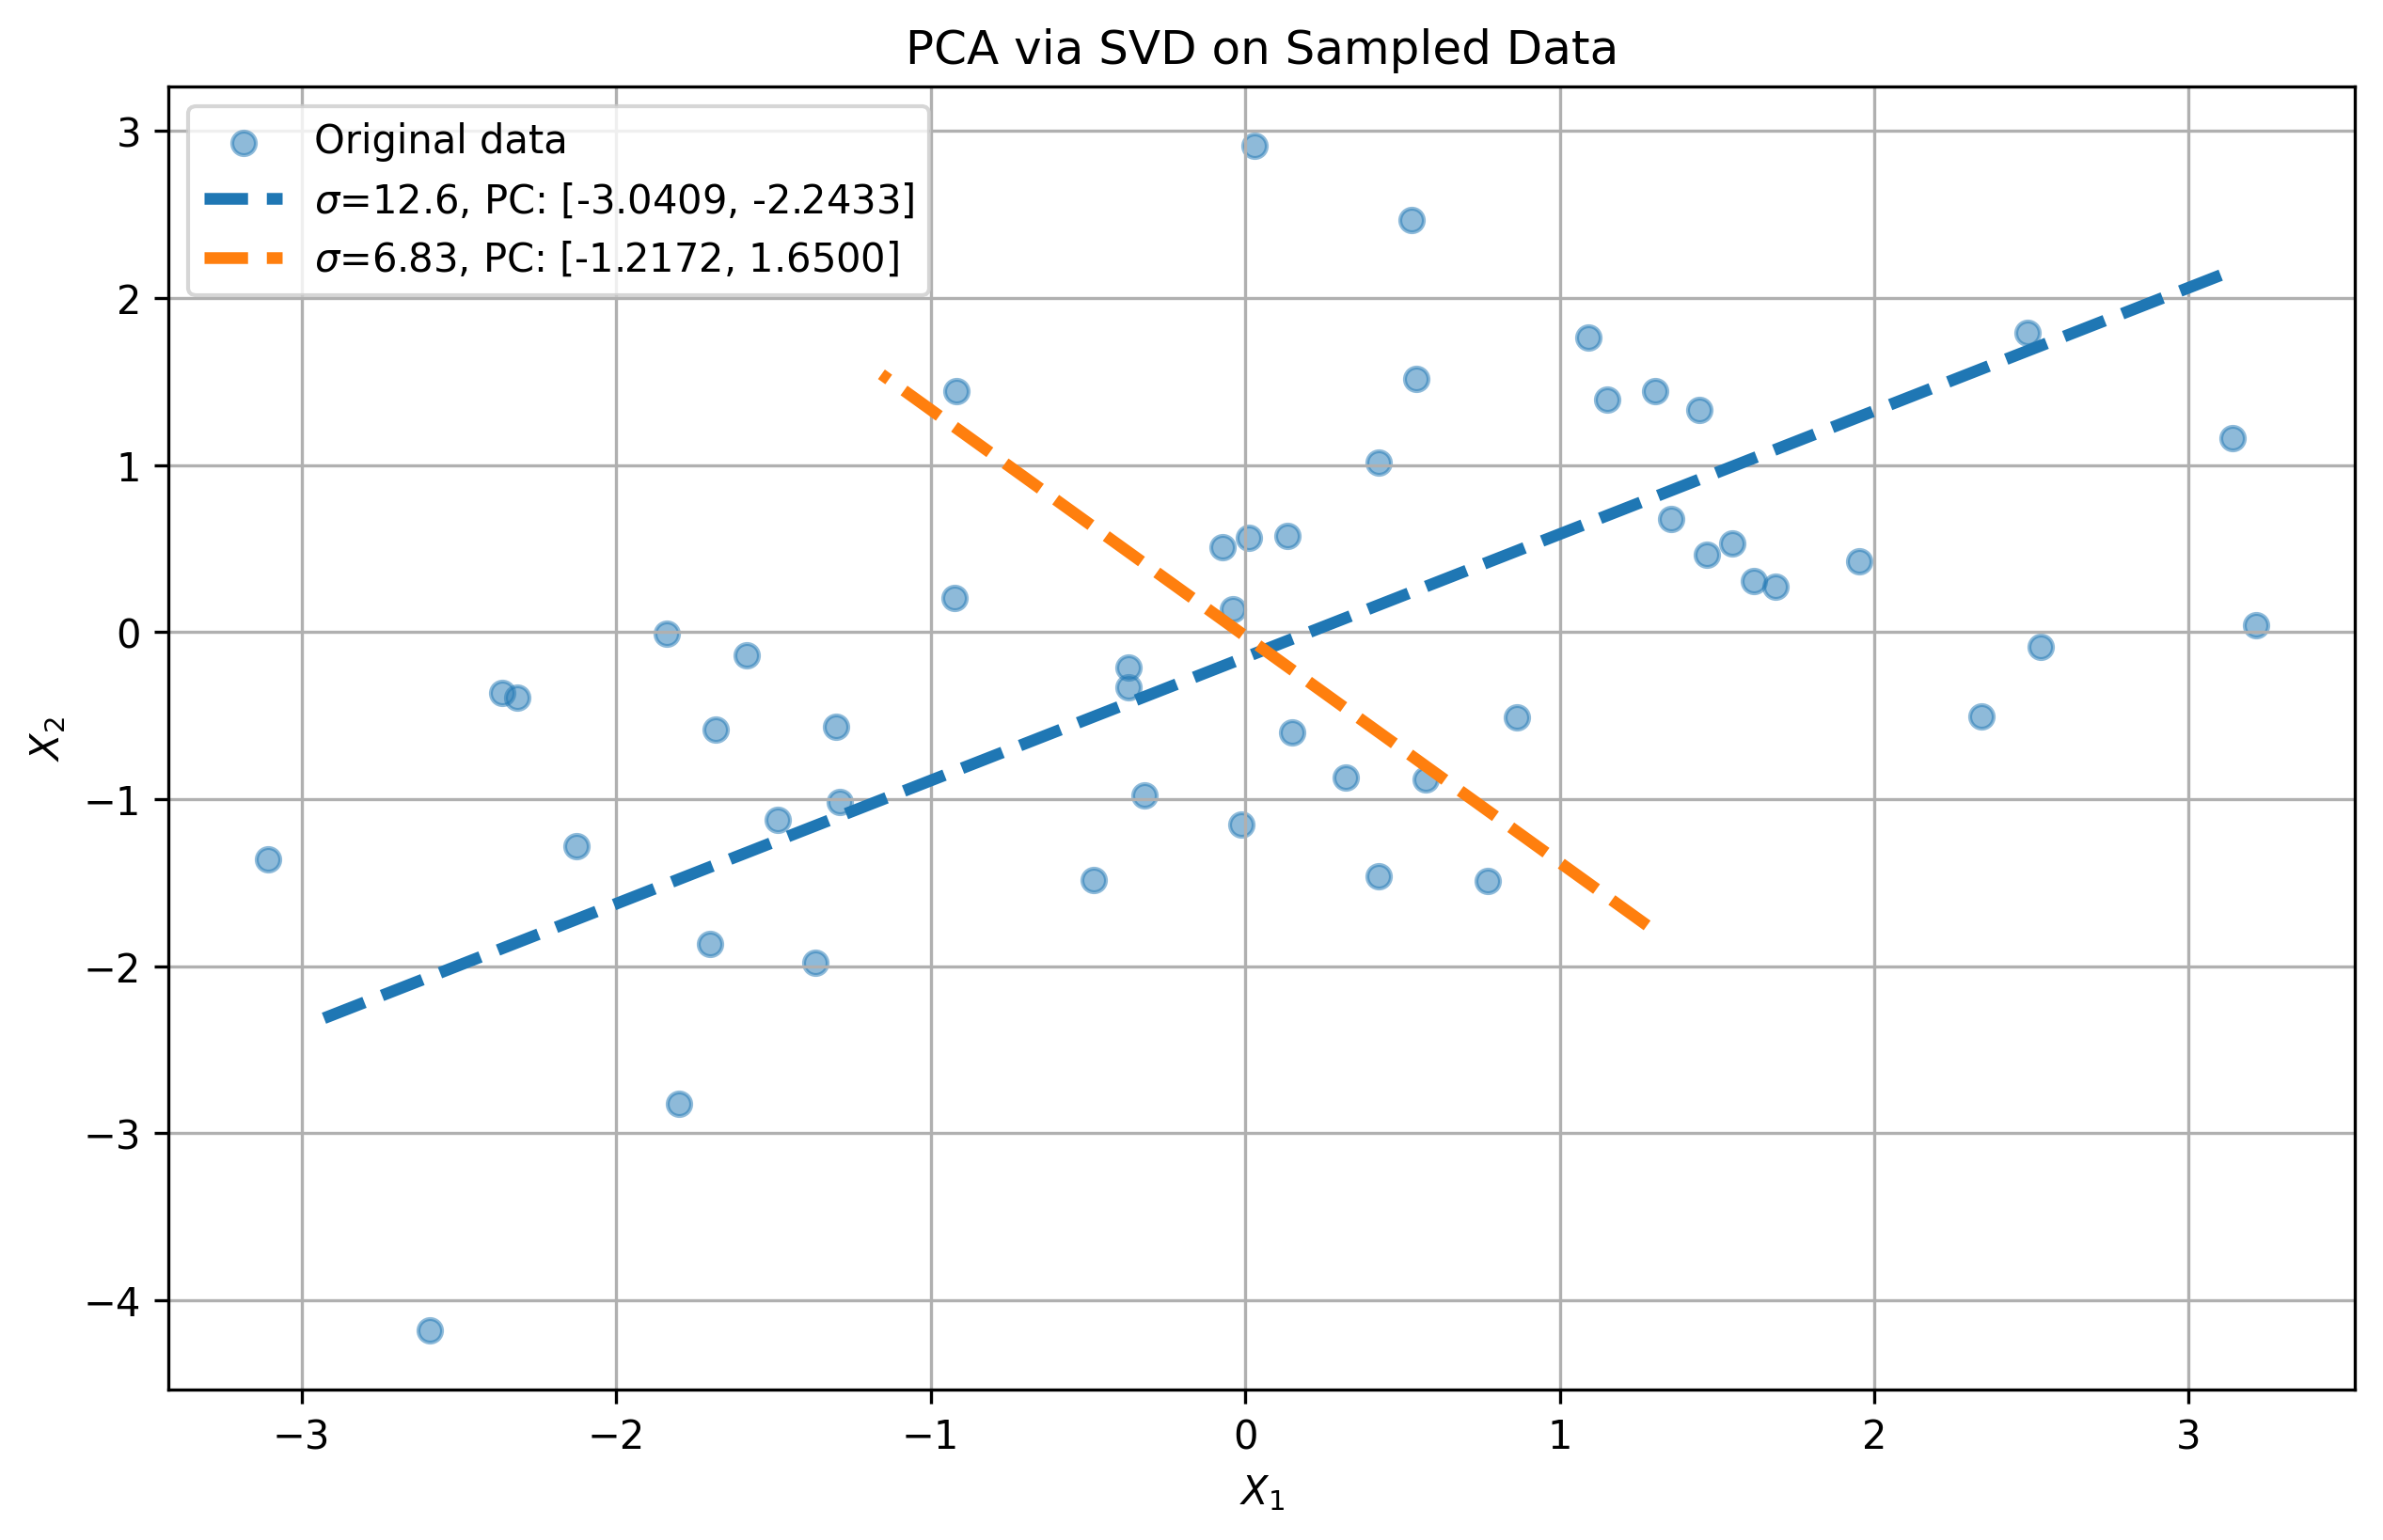

In [134]:
# assume i only get 50 observations randomly
def sample_data(X, size = 50):
    sample_size = 50
    sample_X = X[np.random.choice(X.shape[0], sample_size, replace=False), :]
    return sample_X

def perform_pca(data):
    """
    Perform PCA using SVD on the given data.

    Parameters:
    data (numpy.ndarray): The input data.

    Returns:
    tuple: Singular values (S) and principal components (PCs).
    """
    # Step 1: Center the data
    data_centered = data - np.mean(data, axis=0)
    # Step 2: Apply SVD
    _, S, VT = np.linalg.svd(data_centered)
    # Principal components (directions)
    PCs = VT.T
    return S, PCs

# Call the function with the sampled data
sample_X = sample_data(X)
S, PCs = perform_pca(sample_X)

def visualize_pca(S, PCs, data, ax, title="PCA Visualization"):
    """
    Visualize PCA results on a 2D dataset.

    Parameters:
    S (numpy.ndarray): Singular values from SVD.
    PCs (numpy.ndarray): Principal components from SVD.
    data (numpy.ndarray): Original data to visualize.
    title (str): Title of the plot.

    Returns:
    matplotlib.axes._subplots.AxesSubplot: Axes object of the plot.
    """
    # Step 1: Center the data
    data_centered = data - np.mean(data, axis=0)
    # Step 2: Project the data onto the principal components
    data_pca = data_centered @ PCs

    # Step 3: Create the figure and axes
    ax.scatter(data[:, 0], data[:, 1], alpha=0.5, label='Original data')
    origin = np.mean(data, axis=0)

    # Step 4: Plot principal components
    for length, vector in zip(S, PCs.T):
        v = vector * 0.3 * length  # scale for visualization
        ax.plot([origin[0] - v[0], origin[0] + v[0]],
                [origin[1] - v[1], origin[1] + v[1]],
                linewidth=3,
                linestyle='--',
                label=f'$\\sigma$={round(length, 2)}, PC: [{v[0]:.4f}, {v[1]:.4f}]')

    # Step 5: Customize the plot
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

    return ax

# Example usage
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
axes4 = visualize_pca(S, PCs, sample_X, ax, title="PCA via SVD on Sampled Data")
plt.show()


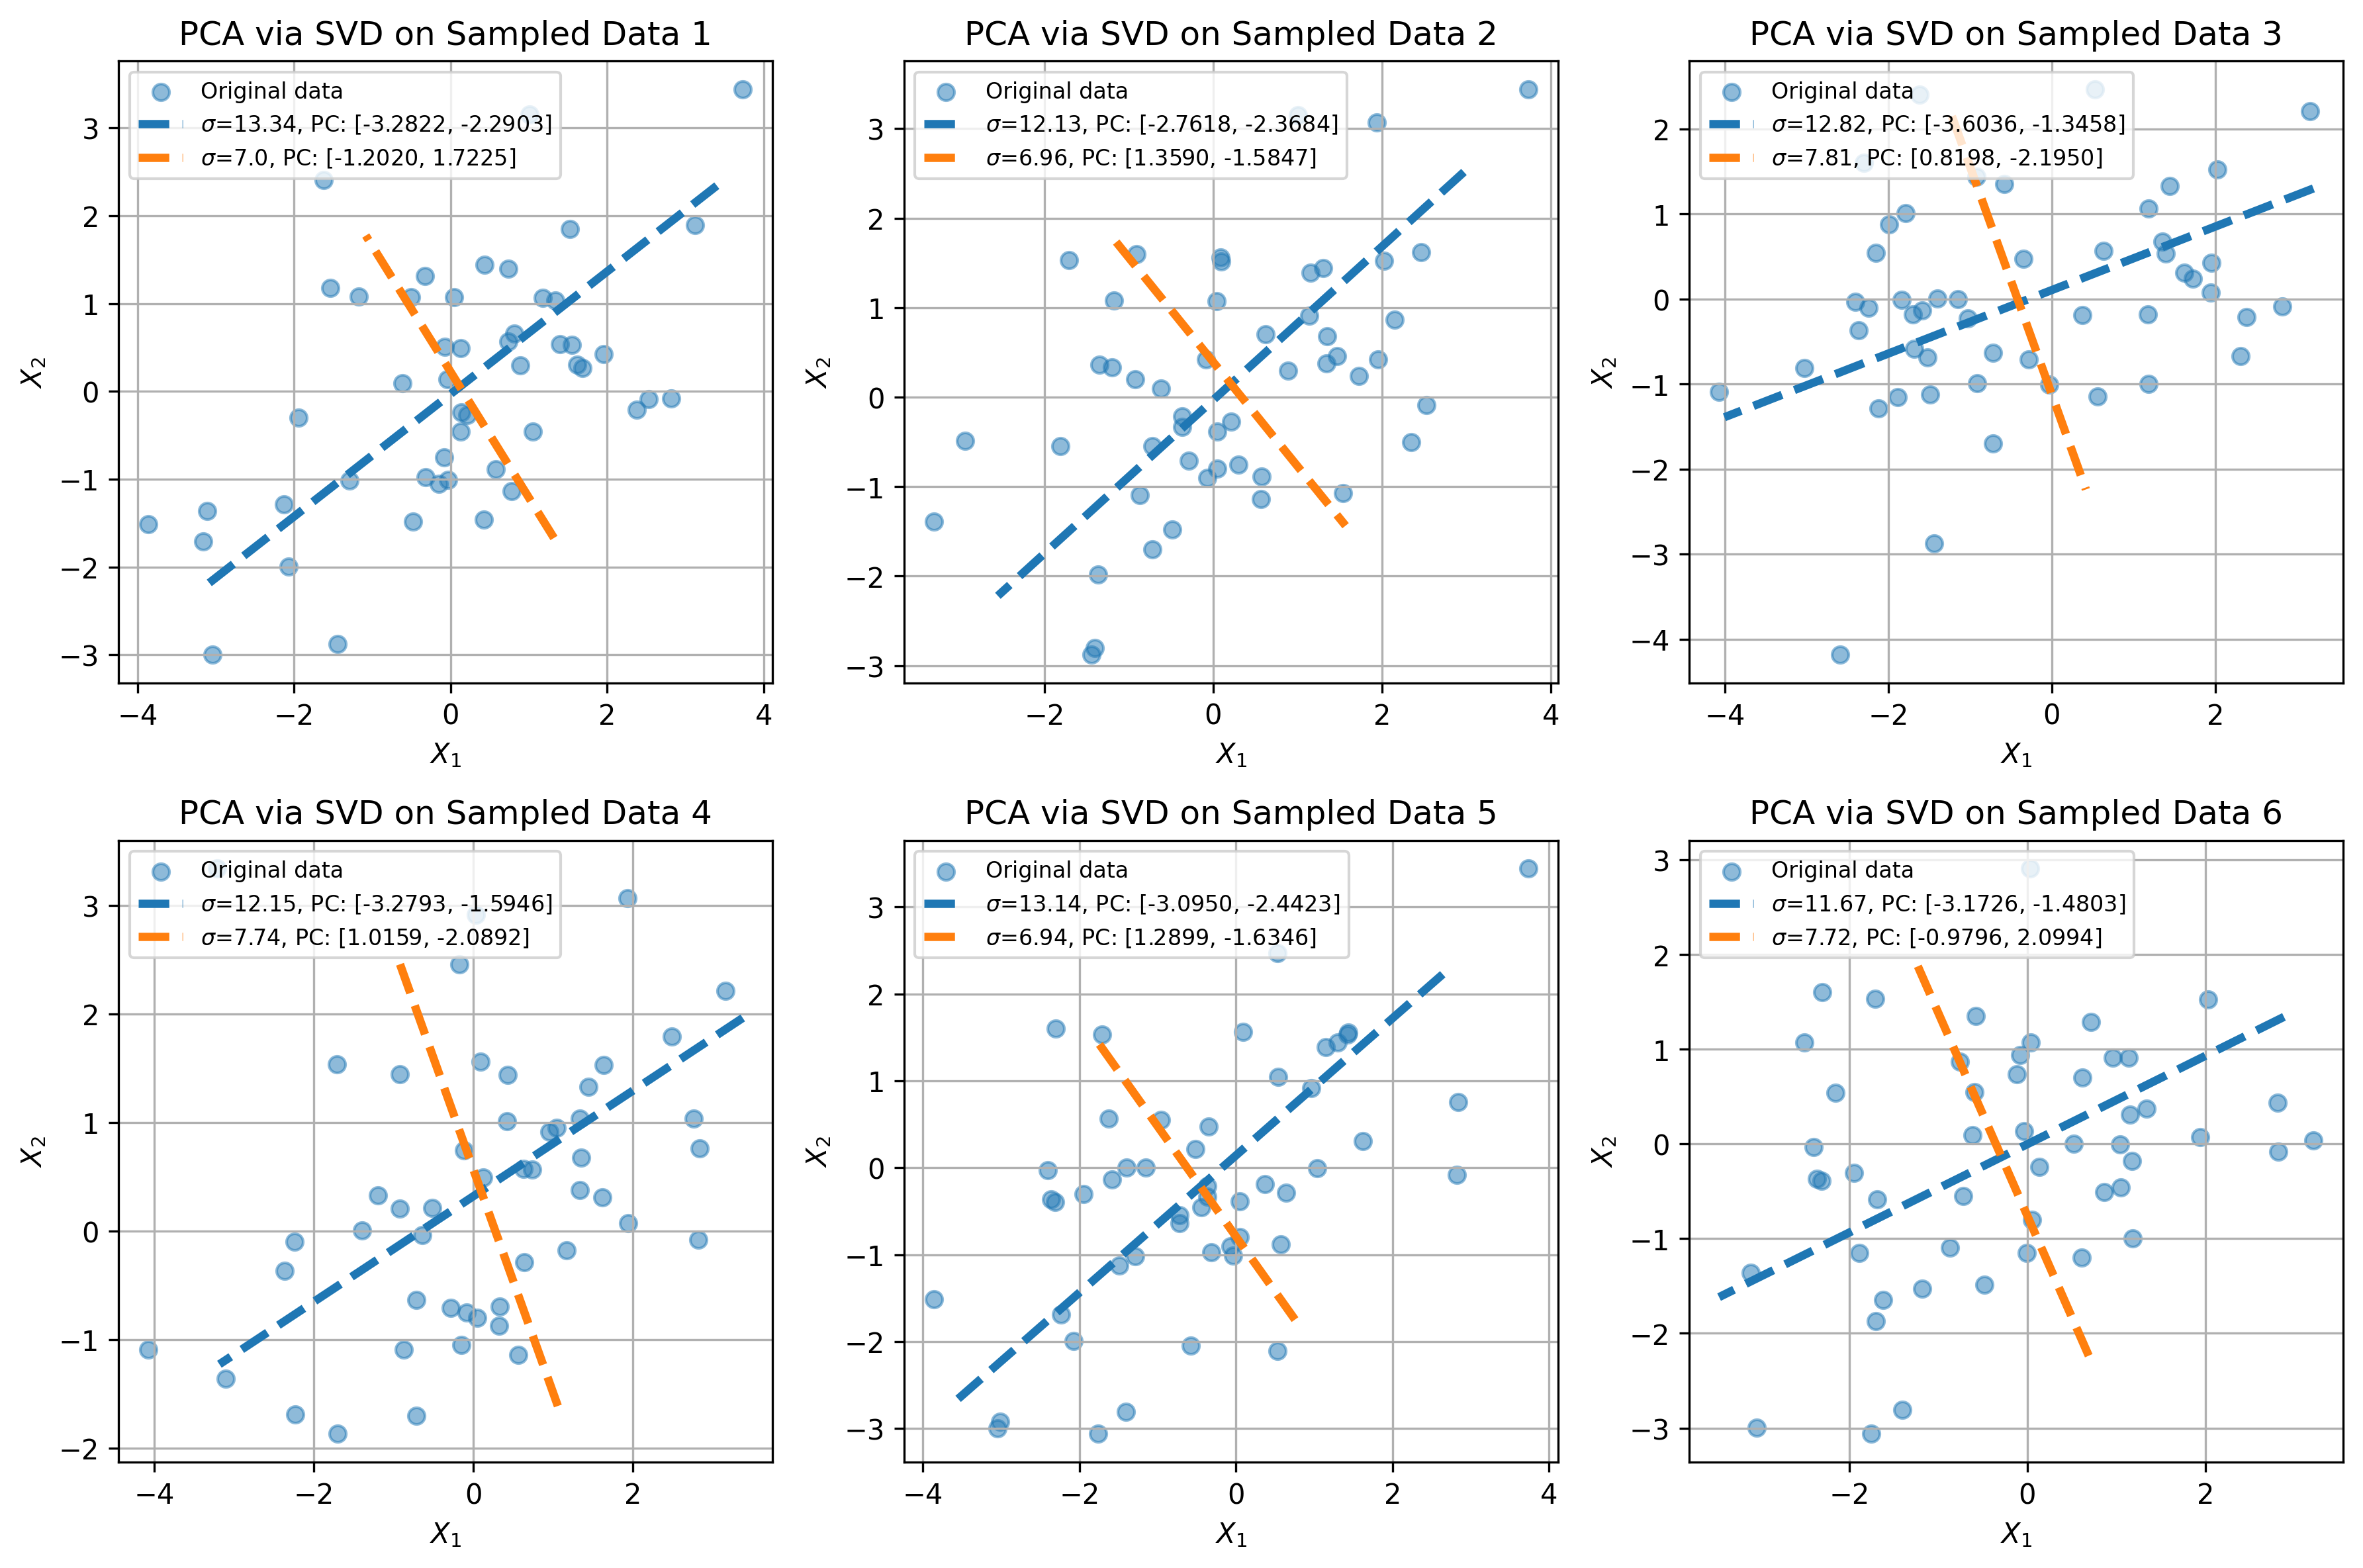

In [142]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), dpi=300)
axes = axes.flatten()
for i in range(6):  # Use the index `i` to iterate over the axes
    # Call the function with the sampled data
    sample_X = sample_data(X)
    S, PCs = perform_pca(sample_X)
    visualize_pca(S, PCs, sample_X, axes[i], title=f"PCA via SVD on Sampled Data {i+1}")
    axes[i].legend(fontsize=8, loc='upper left')
fig.tight_layout()
fig.savefig("results/pca_svd_sampled_data.png", dpi=300)

In [126]:
# do bootsrapping on the sampled data with B = 50 times
def bootstrap_pca(data, B=50):
    """
    Perform PCA on bootstrapped samples of the data.

    Parameters:
    data (numpy.ndarray): The input data.
    B (int): Number of bootstrap samples.

    Returns:
    list: List of tuples containing singular values and principal components for each bootstrap sample.
    """
    bootstrap_S = list()
    bootstrap_PCs = list()
    n = data.shape[0]
    for _ in range(B):
        # Generate a bootstrap sample
        indices = np.random.choice(n, n, replace=True)
        sample_data = data[indices]
        S, PCs = perform_pca(sample_data)
        bootstrap_S.append(S)
        bootstrap_PCs.append(PCs)
    return np.array(bootstrap_S), np.array(bootstrap_PCs)

# Call the function with the sampled data
sample_X = sample_data(X, size = 200)
bootstrap_S, bootstrap_PCs = bootstrap_pca(X, B=1)
bootstrap_S.mean(axis = 0)

array([26.85514361, 13.90179493])

# Put all the axes objects onto a figure.

<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_86373/4204577858.py:29: SyntaxWarning: invalid escape sequence '\s'
  label=f'$\sigma=${round(length, 2)}, PC:{v.round(4)}')


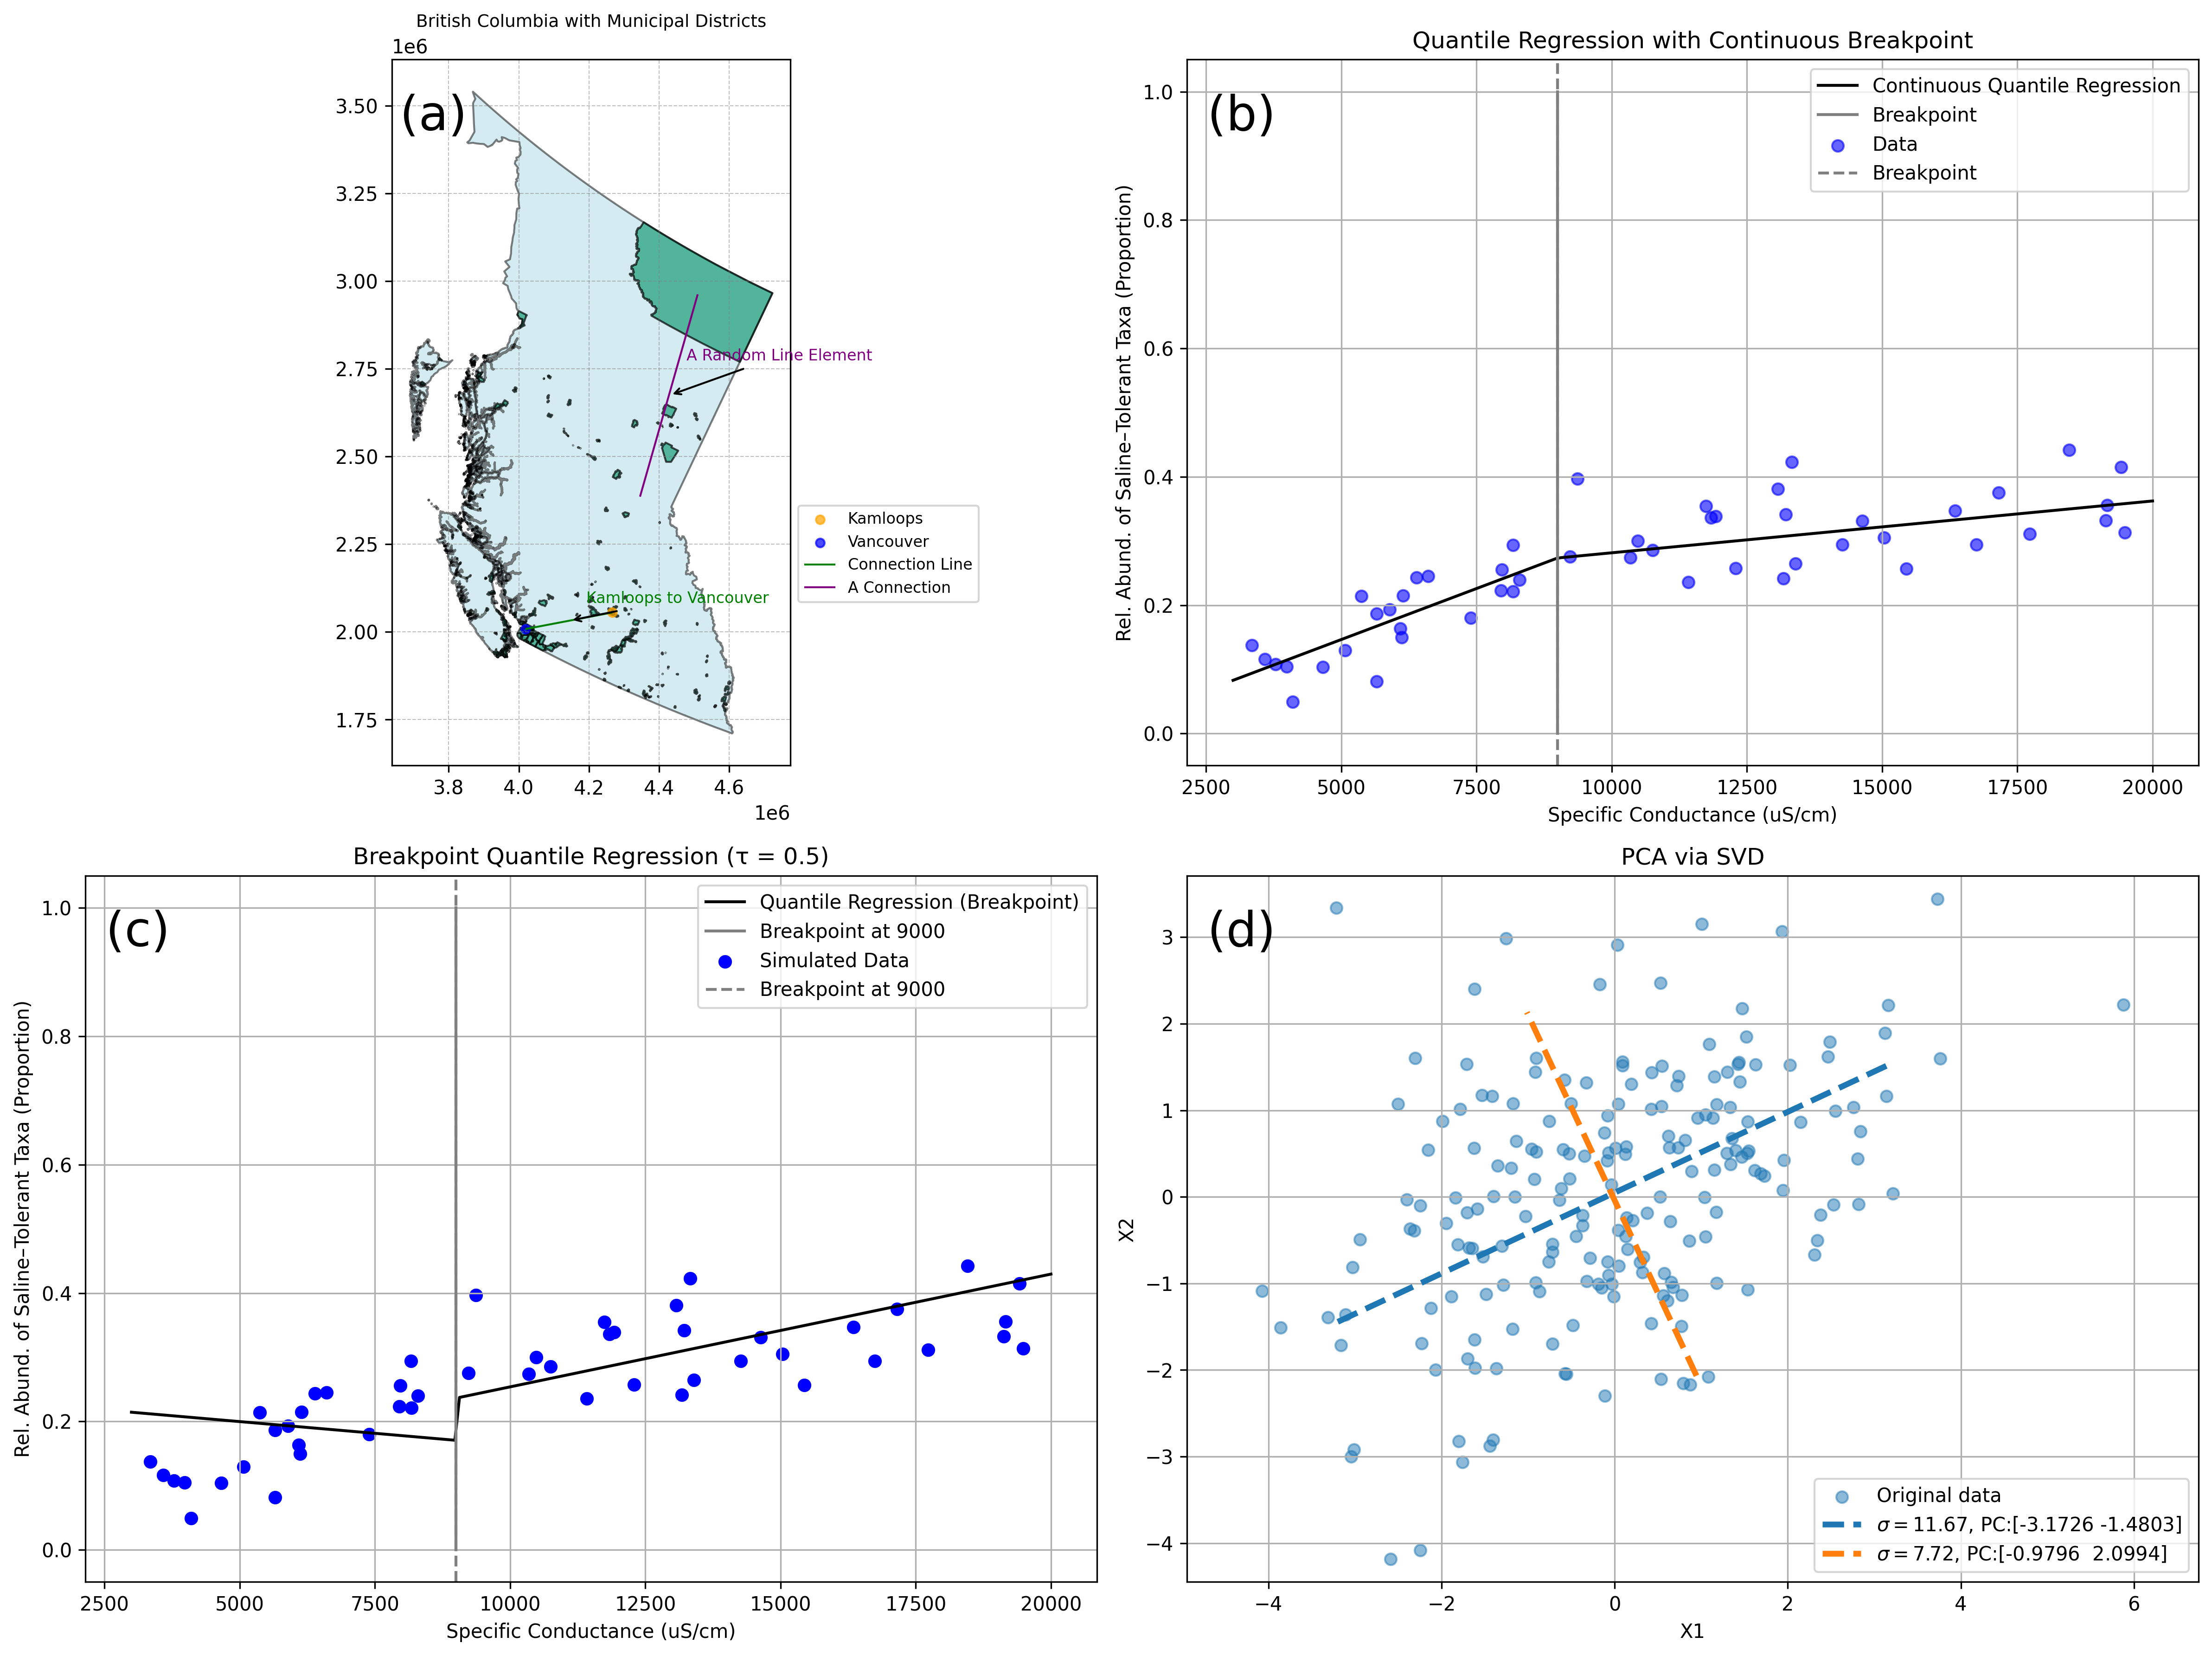

In [145]:

# Create a new figure with a 2x2 grid
fig_combined_all, axes_combined_all = plt.subplots(2, 2, figsize=(16, 12), dpi=300)

# Copy the content of ax to the top-right subplot
map_plot(axes_combined_all[0, 0])
axes_combined_all[0, 0].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
axes_combined_all[0, 0].legend(fontsize=8, loc='center left', bbox_to_anchor=(1, 0.3))

# Copy the content of axes2 to the top-right subplot
for line in axes2.get_lines():
    axes_combined_all[0, 1].plot(line.get_xdata(), line.get_ydata(), label=line.get_label(), color=line.get_color())
axes_combined_all[0, 1].scatter(df['x'], df['y'], color='blue', label='Data', alpha=0.6)
axes_combined_all[0, 1].axvline(x=breakpoint, color='gray', linestyle='--', label='Breakpoint')
axes_combined_all[0, 1].set_title(axes2.get_title())
axes_combined_all[0, 1].set_xlabel(axes2.get_xlabel())
axes_combined_all[0, 1].set_ylabel(axes2.get_ylabel())
axes_combined_all[0, 1].legend()
axes_combined_all[0, 1].grid(True)

# Copy the content of axes3 to the bottom-right subplot
axes_combined_all[1, 1].scatter(X[:, 0], X[:, 1], alpha=0.5, label='Original data')
origin = np.mean(X, axis=0)
for length, vector in zip(S, PCs.T):
    v = vector * 0.3 * length  # scale for visualization
    axes_combined_all[1, 1].plot([origin[0] - v[0], origin[0] + v[0]],
                                 [origin[1] - v[1], origin[1] + v[1]],
                                 linewidth=3,
                                 linestyle='--',
                                 label=f'$\sigma=${round(length, 2)}, PC:{v.round(4)}')
axes_combined_all[1, 1].set_xlabel('X1')
axes_combined_all[1, 1].set_ylabel('X2')
axes_combined_all[1, 1].set_title("PCA via SVD")
axes_combined_all[1, 1].axis('equal')
axes_combined_all[1, 1].grid(True)
axes_combined_all[1, 1].legend()

# Copy the content of ax1 to the bottom-left subplot
for line in ax1.get_lines():
    axes_combined_all[1, 0].plot(line.get_xdata(), line.get_ydata(), label=line.get_label(), color=line.get_color())
axes_combined_all[1, 0].scatter(df['x'], df['y'], color='blue', label='Simulated Data')
axes_combined_all[1, 0].axvline(breakpoint, color='gray', linestyle='--', label=f'Breakpoint at {breakpoint}')
axes_combined_all[1, 0].set_title(ax1.get_title())
axes_combined_all[1, 0].set_xlabel(ax1.get_xlabel())
axes_combined_all[1, 0].set_ylabel(ax1.get_ylabel())
axes_combined_all[1, 0].legend()
axes_combined_all[1, 0].grid(True)

# Adjust layout and show the combined figure
axes_combined_all[0, 0].text(0.02, 0.90, "(a)", transform=axes_combined_all[0, 0].transAxes, fontsize=25)
axes_combined_all[0, 1].text(0.02, 0.90, "(b)", transform=axes_combined_all[0, 1].transAxes, fontsize=25)
axes_combined_all[1, 0].text(0.02, 0.90, "(c)", transform=axes_combined_all[1, 0].transAxes, fontsize=25)
axes_combined_all[1, 1].text(0.02, 0.90, "(d)", transform=axes_combined_all[1, 1].transAxes, fontsize=25)

fig_combined_all.tight_layout()
fig_combined_all.savefig("results/combined_plot.png", dpi=300)
plt.show()